In [114]:
from captum.attr import IntegratedGradients

In [115]:
ig = IntegratedGradients(model)

In [ ]:
test_dataset.X.shape  # test_dataset type is NetCDFDataset

torch.Size([17897, 19, 5, 9, 11])

In [117]:
test_dataset.y.shape

torch.Size([17897, 1, 5, 9, 11])

In [118]:
mask = (test_dataset.y[:, 0, :, :, :] >= 37.5).any(axis=(1, 2, 3))
# since [17897, 19, 5, 9, 11] is samples x channels x time x lat x lon, axis=(1,2,3) means we are checking across channels, time, lat and lon dimensions
X_selected = test_dataset.X[mask]
y_selected = test_dataset.y[mask]
print(X_selected.shape, y_selected.shape)

torch.Size([482, 19, 5, 9, 11]) torch.Size([482, 1, 5, 9, 11])


In [119]:
# test_input_tensor = test_loader
# given the shape torch.Size([17897, 1, 5, 9, 11]), where 17897 is the number of samples, we'll get only the first 1000:

# test_input_tensor = test_dataset.X[:1000].to(device)
# test_input_tensor = test_dataset.X[:10].to(device)
# test_input_tensor = test_dataset.X[:500].to(device)
test_input_tensor = test_dataset.X[:50].to(device)  # important

# get the first 50 samples where test_dataset.y[:, 0, :, :, :] >= 37.5 from X_selected and y_selected
# test_input_tensor = X_selected[:50]
# y_selected = y_selected[:50]

In [120]:
del test_dataset

In [121]:
test_input_tensor.shape

torch.Size([50, 19, 5, 9, 11])

In [122]:
test_output = model(test_input_tensor[:5])
test_output.shape

torch.Size([5, 1, 5, 9, 11])

In [123]:
"""
My code:
test_output = model(test_input_tensor[:5])
test_output.shape # torch.Size([5, 1, 5, 9, 11])

Docs of captum:
For outputs with > 2 dimensions, targets can be either:

                        - A single tuple, which contains #output_dims - 1
                          elements. This target index is applied to all examples.

                        - A list of tuples with length equal to the number of
                          examples in inputs (dim 0), and each tuple containing
                          #output_dims - 1 elements. Each tuple is applied as the
                          target for the corresponding example.
"""

# Single target for all samples: (channel, timestep, lat, lon)

LATS_INDEXES = slice(4, 5)
LONS_INDEXES = slice(5, 8)

channel = 0  # precipitation channel
timestep = 0  # first timestep
lat = 4  # fifth latitude index (top to bottom)
lon = 7  # eighth longitude index (left to right)


attr = ig.attribute(test_input_tensor, target=(channel, timestep, lat, lon))
attr = attr.detach().numpy()

In [124]:
attr.shape  # 10 samples x 19 channels x 5 timesteps x 9 latitudes x 11 longitudes

(50, 19, 5, 9, 11)

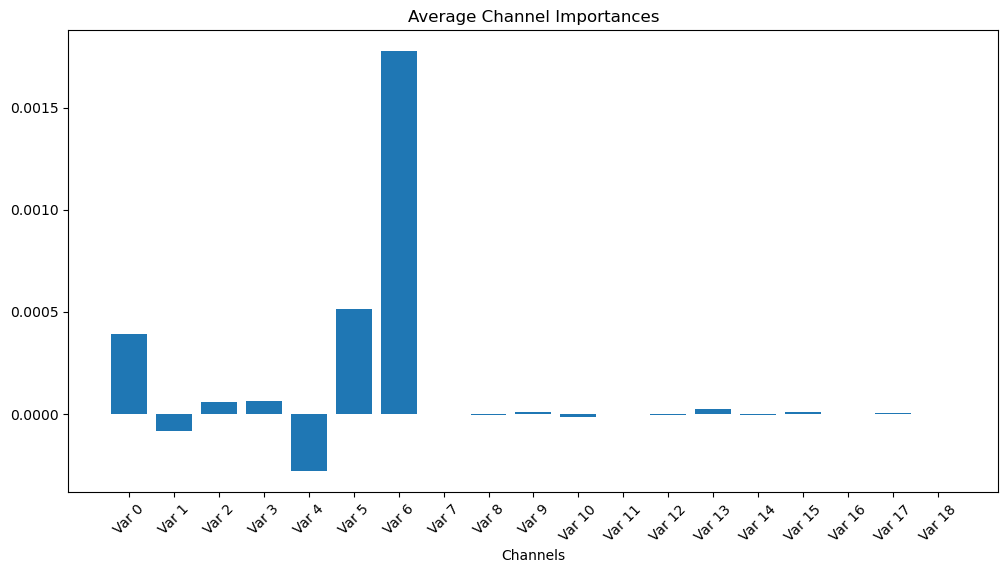

Var 0: 0.000
Var 1: -0.000
Var 2: 0.000
Var 3: 0.000
Var 4: -0.000
Var 5: 0.001
Var 6: 0.002
Var 7: -0.000
Var 8: -0.000
Var 9: 0.000
Var 10: -0.000
Var 11: 0.000
Var 12: -0.000
Var 13: 0.000
Var 14: -0.000
Var 15: 0.000
Var 16: 0.000
Var 17: 0.000
Var 18: -0.000


In [125]:
# Example 1: Visualize average importance per channel
# Aggregate over samples, timesteps, latitudes, and longitudes:


def visualize_importances_channels(attr, channel_names=None, title="Average Channel Importances"):
    # attr shape: (samples, channels, timesteps, latitudes, longitudes)
    importances = np.mean(attr, axis=(0, 2, 3, 4))  # shape: (channels,)
    if channel_names is None:
        channel_names = [f"Channel {i}" for i in range(importances.shape[0])]
    x_pos = np.arange(len(channel_names))
    plt.figure(figsize=(12, 6))
    plt.bar(x_pos, importances, align="center")
    plt.xticks(x_pos, channel_names, rotation=45)
    plt.xlabel("Channels")
    plt.title(title)
    plt.show()
    for i, name in enumerate(channel_names):
        print(f"{name}: {importances[i]:.3f}")


# Usage:
visualize_importances_channels(attr, channel_names=[f"Var {i}" for i in range(attr.shape[1])])

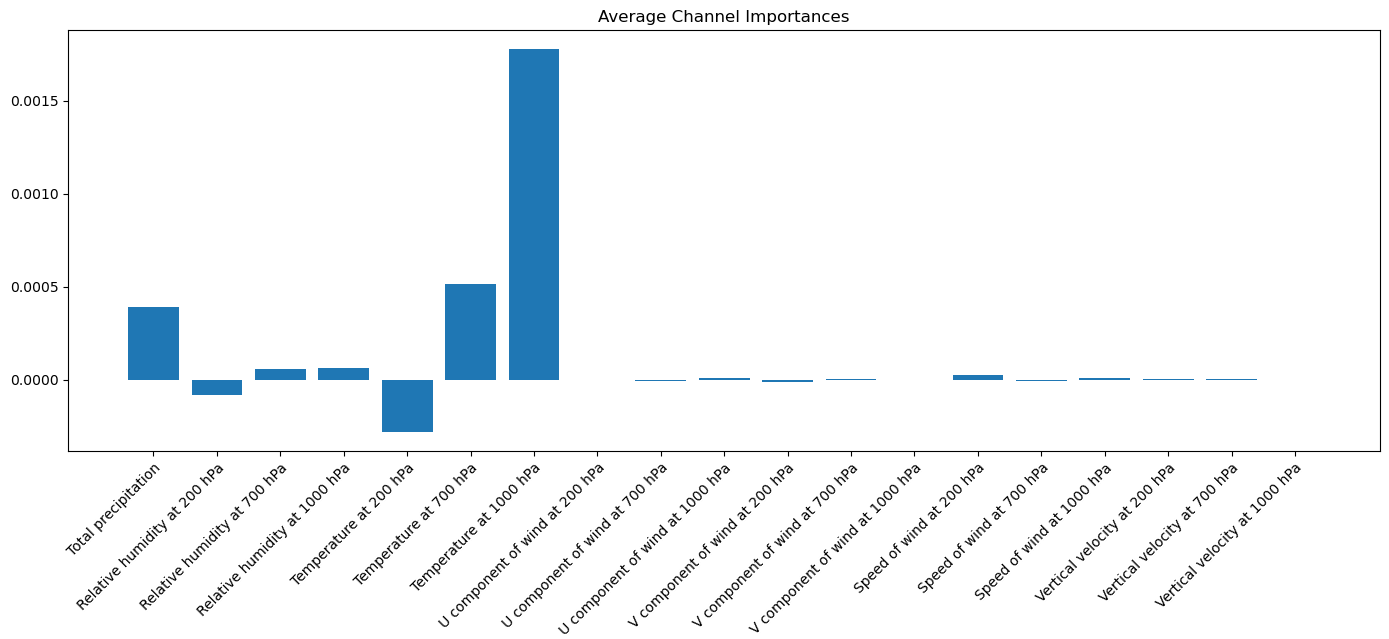

Total precipitation: 0.000
Relative humidity at 200 hPa: -0.000
Relative humidity at 700 hPa: 0.000
Relative humidity at 1000 hPa: 0.000
Temperature at 200 hPa: -0.000
Temperature at 700 hPa: 0.001
Temperature at 1000 hPa: 0.002
U component of wind at 200 hPa: -0.000
U component of wind at 700 hPa: -0.000
U component of wind at 1000 hPa: 0.000
V component of wind at 200 hPa: -0.000
V component of wind at 700 hPa: 0.000
V component of wind at 1000 hPa: -0.000
Speed of wind at 200 hPa: 0.000
Speed of wind at 700 hPa: -0.000
Speed of wind at 1000 hPa: 0.000
Vertical velocity at 200 hPa: 0.000
Vertical velocity at 700 hPa: 0.000
Vertical velocity at 1000 hPa: -0.000


In [126]:
features_tuple = {
    "tp": "Total precipitation",
    "r200": "Relative humidity at 200 hPa",
    "r700": "Relative humidity at 700 hPa",
    "r1000": "Relative humidity at 1000 hPa",
    "t200": "Temperature at 200 hPa",
    "t700": "Temperature at 700 hPa",
    "t1000": "Temperature at 1000 hPa",
    "u200": "U component of wind at 200 hPa",
    "u700": "U component of wind at 700 hPa",
    "u1000": "U component of wind at 1000 hPa",
    "v200": "V component of wind at 200 hPa",
    "v700": "V component of wind at 700 hPa",
    "v1000": "V component of wind at 1000 hPa",
    "speed200": "Speed of wind at 200 hPa",
    "speed700": "Speed of wind at 700 hPa",
    "speed1000": "Speed of wind at 1000 hPa",
    "w200": "Vertical velocity at 200 hPa",
    "w700": "Vertical velocity at 700 hPa",
    "w1000": "Vertical velocity at 1000 hPa",
}


def visualize_importances_channels(attr, feature_names=None, title="Average Channel Importances"):
    # attr shape: (samples, channels, timesteps, latitudes, longitudes)
    importances = np.mean(attr, axis=(0, 2, 3, 4))  # shape: (channels,)
    if feature_names is None:
        feature_names = list(features_tuple.values())
    x_pos = np.arange(len(feature_names))
    plt.figure(figsize=(14, 6))
    plt.bar(x_pos, importances, align="center")
    plt.xticks(x_pos, feature_names, rotation=45, ha="right", wrap=True)
    plt.xlabel("Features")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    for i, name in enumerate(feature_names):
        print(f"{name}: {importances[i]:.3f}")


visualize_importances_channels(attr, feature_names=list(features_tuple.values()))

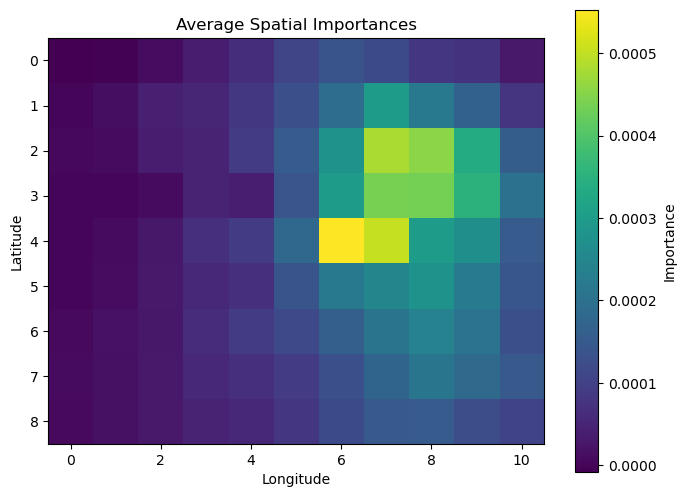

In [ ]:
# Example 2: Visualize average importance per latitude/longitude (spatial map)
# Aggregate over samples, channels, and timesteps:


def visualize_importances_spatial(attr, title="Average Spatial Importances"):
    # attr shape: (samples, channels, timesteps, latitudes, longitudes)
    importances = np.mean(attr, axis=(0, 1, 2))  # shape: (latitudes, longitudes)
    plt.figure(figsize=(8, 6))
    plt.imshow(importances, cmap="viridis")
    plt.colorbar(label="Importance")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.show()


# Usage:
visualize_importances_spatial(attr)


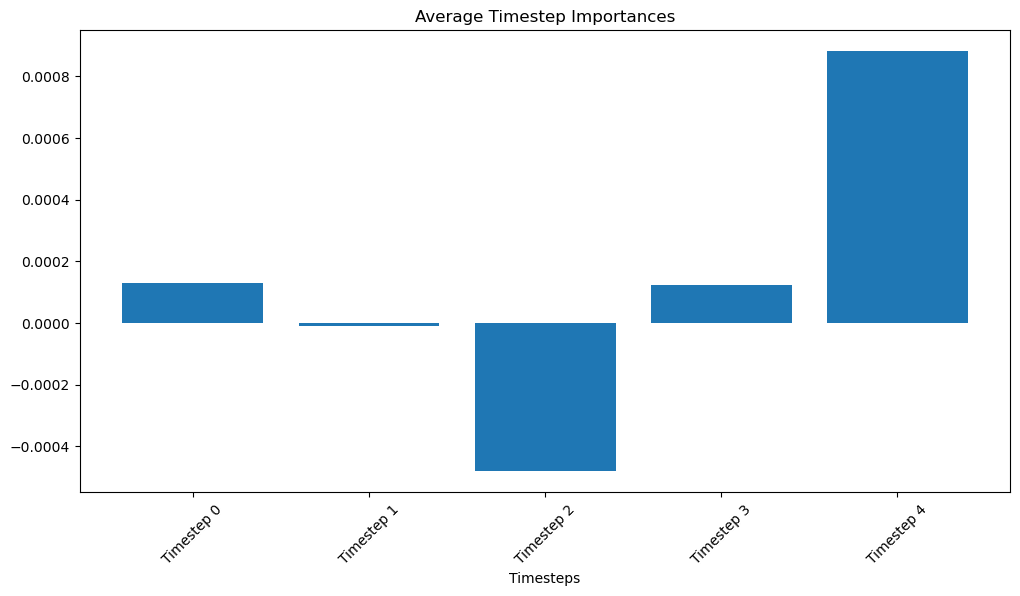

Timestep 0: 0.000
Timestep 1: -0.000
Timestep 2: -0.000
Timestep 3: 0.000
Timestep 4: 0.001


In [128]:
# Example3: aggregate over samples, channels, latitudes, and longitudes, leaving only the timesteps axis.


def visualize_importances_timesteps(attr, timestep_names=None, title="Average Timestep Importances"):
    # attr shape: (samples, channels, timesteps, latitudes, longitudes)
    importances = np.mean(attr, axis=(0, 1, 3, 4))  # shape: (timesteps,)
    if timestep_names is None:
        timestep_names = [f"Timestep {i}" for i in range(importances.shape[0])]
    x_pos = np.arange(len(timestep_names))
    plt.figure(figsize=(12, 6))
    plt.bar(x_pos, importances, align="center")
    plt.xticks(x_pos, timestep_names, rotation=45)
    plt.xlabel("Timesteps")
    plt.title(title)
    plt.show()
    for i, name in enumerate(timestep_names):
        print(f"{name}: {importances[i]:.3f}")


# Usage:
visualize_importances_timesteps(attr)